# Setup

In [1]:
import sys
import os

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from custom_metrics import *

## Utility functions

In [2]:
# Utility function to extract bits of info on a run from its filename
def get_run_info_from_fname(filename):
    bits = filename.split('_')

    model = bits[0]
    assert bits[0] in ['pymer', 'FLAML', 'dummy'], f'Model "{bits[0]}" is not currently implemented in this function'
    
    if model == 'pymer':
        model_name = bits[0 : 4]
        i = 4
    elif model == 'FLAML': 
        model_name = bits[0 : 3]
        i = 3
    elif model == 'dummy':
        model_name = bits[0 : 2]
        i = 2
    model_name = '_'.join(model_name)

    if bits[i + 1] == 'extended':
        dataset = bits[i : i + 2]
        dataset = '_'.join(dataset)
        i += 2
    else:
        dataset = bits[i]
        i += 1
    
    num_folds = bits[i]
    num_folds = int(num_folds.removesuffix('-fold'))
    i += 1

    block_type = bits[i]
    block_type = block_type.removesuffix('.csv').removesuffix('-blocking')
    i += 1

    spatial_spacing = None
    group_col = None
    
    if block_type == 'spatial':
        spatial_spacing = bits[i]
        spatial_spacing = int(spatial_spacing.removesuffix('-degree.csv'))
    elif block_type == 'group':
        group_col = bits[i]
        group_col = group_col.removesuffix('.csv')

    return_dict = {'model_name' : model_name, 
                   'dataset' : dataset, 
                   'num_folds' : num_folds, 
                   'block_type' : block_type,
                   'spatial_spacing' : spatial_spacing,
                   'group_col' : group_col,
                   'filename' : filename}

    return return_dict

In [3]:
# Utility function to apply a metric by fold and then get avg/standard dev over folds
def get_metric_CV(raw_preds, metric, **kwargs):
    raw_preds = raw_preds.groupby('fold')
    metric_by_group = raw_preds.apply(lambda x: metric(x['actual'], x['predicted'], **kwargs), include_groups = False)
    
    metric_mean = metric_by_group.mean()
    metric_std = metric_by_group.std()

    return metric_mean, metric_std

# Evaluating with new metrics

In [4]:
# Read in the raw predictions from the nonlinear hurdle w/ and w/o additional predictors
raw_preds_path = '../phd_results/raw_predictions'
runs_to_eval = ['FLAML_hurdle_2.0mins_birds_5-fold_random-blocking.csv',
                'FLAML_hurdle_2.0mins_birds_extended_5-fold_random-blocking.csv',
                'pymer_hurdle_wo_rfx_birds_5-fold_random-blocking.csv',
                'dummy_regressor_birds_5-fold_random-blocking.csv']

#  get run info and read in raw prediction dataframe
runs_to_eval = [get_run_info_from_fname(r) for r in runs_to_eval]

for r in runs_to_eval:
    df = pd.read_csv(os.path.join(raw_preds_path, r['filename']), index_col = 'index')
    r['raw_preds'] = df
    r['new_metrics'] = {}

In [5]:
# Fiddling with the new metrics
#  balanced accuracy on the new DI categories
neighborhood = 0.05

for r in runs_to_eval:
    ba_mean, ba_std = get_metric_CV(r['raw_preds'], balanced_accuracy_DI_cats, **{'neighborhood' : neighborhood})
    r['new_metrics'][f'balanced_accuracy_{neighborhood}'] = {'mean' : ba_mean, 'standard_deviation' : ba_std}

#  mean absolute percentage error
tau = 0.05

for r in runs_to_eval:
    mape_mean, mape_std = get_metric_CV(r['raw_preds'], mean_absolute_percent_error_tau, **{'tau' : tau})
    r['new_metrics'][f'mape_{tau}'] = {'mean' : mape_mean, 'standard_deviation' : mape_std}

#  wasserstein distance for distributional similarity
upper_thresh = 2

for r in runs_to_eval:
    raw_preds_thresh = r['raw_preds']
    raw_preds_thresh = raw_preds_thresh[(raw_preds_thresh['actual'] <= upper_thresh) & (raw_preds_thresh['actual'] >= 0)]
    
    wass_mean, wass_std = get_metric_CV(raw_preds_thresh, wasserstein_distance)
    r['new_metrics'][f'wasserstein_{upper_thresh}'] = {'mean' : wass_mean, 'standard_deviation' : wass_std}

In [6]:
# Turning new metric results into a dataframe
new_metrics = pd.DataFrame(columns = ['metric', 'mean', 'standard_deviation', 'model_name', 'dataset', 
                                      'num_folds', 'block_type', 'spatial_spacing', 'group_col'])

i = 0
for r in runs_to_eval:
    new_metrics_vals = r['new_metrics']
    for m in new_metrics_vals.keys():
        row = [m, new_metrics_vals[m]['mean'], new_metrics_vals[m]['standard_deviation'], r['model_name'], r['dataset'], 
               r['num_folds'], r['block_type'], r['spatial_spacing'], r['group_col']]
        
        new_metrics.loc[i] = row
        i += 1

new_metrics

,metric,mean,standard_deviation,model_name,dataset,num_folds,block_type,spatial_spacing,group_col
0,balanced_accuracy_0.05,0.386707,0.027833,FLAML_hurdle_2.0mins,birds,5,random,None,None
1,mape_0.05,0.867842,0.078867,FLAML_hurdle_2.0mins,birds,5,random,None,None
2,wasserstein_2,0.171189,0.020065,FLAML_hurdle_2.0mins,birds,5,random,None,None
3,balanced_accuracy_0.05,0.381219,0.042564,FLAML_hurdle_2.0mins,birds_extended,5,random,None,None
4,mape_0.05,0.831000,0.083367,FLAML_hurdle_2.0mins,birds_extended,5,random,None,None
5,wasserstein_2,0.173068,0.028699,FLAML_hurdle_2.0mins,birds_extended,5,random,None,None
6,balanced_accuracy_0.05,0.306605,0.020371,pymer_hurdle_wo_rfx,birds,5,random,None,None
7,mape_0.05,0.900168,0.053353,pymer_hurdle_wo_rfx,birds,5,random,None,None
8,wasserstein_2,0.221529,0.060272,pymer_hurdle_wo_rfx,birds,5,random,None,None
9,balanced_accuracy_0.05,0.250000,0.000000,dummy_regressor,birds,5,random,None,None


In [10]:
# Saving the results as a CSV for visualization in R
save_results = True

if save_results:
    new_metrics.to_csv('/Users/emiliolr/Desktop/new_metrics_random_blocking.csv', index = False)

## Misc exploration

Evaluating FLAML_hurdle_2.0mins_birds_extended_5-fold_random-blocking.csv



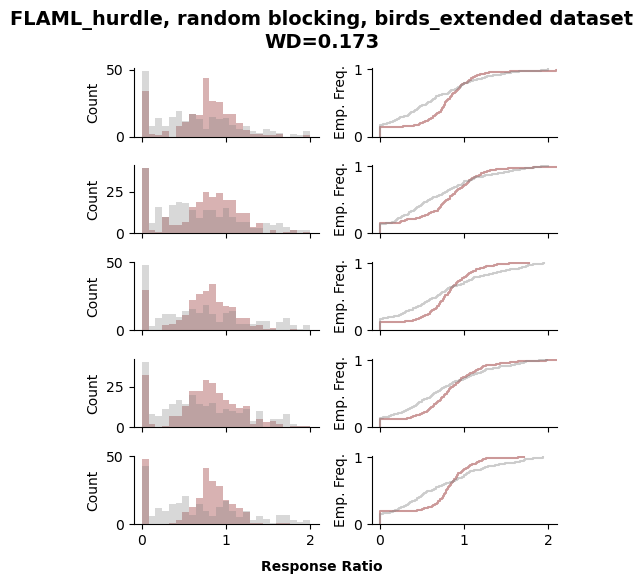

In [12]:
# Looking at histograms/eCDFs of actual/predicted per fold and corresponding Wasserstein distance
max_val = 2
run = runs_to_eval[1]

print(f'Evaluating {run["filename"]}\n')

raw_preds = run['raw_preds']
wds = []

fig, axs = plt.subplots(5, 2, figsize = (5, 6), sharex = True)

for fold in range(0, 5):
    d = raw_preds[raw_preds['fold'] == fold]
    d = d[(d['actual'] <= max_val) & (d['actual'] >= 0)]

    #  histogram
    sns.histplot(data = d, x = 'predicted', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'maroon', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val), ax = axs[fold, 0])
    sns.histplot(data = d, x = 'actual', stat = 'count', kde = False, legend = False, bins = 25, 
                 color = 'grey', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val), ax = axs[fold, 0])

    axs[fold, 0].spines['top'].set_visible(False)
    axs[fold, 0].spines['right'].set_visible(False)

    axs[fold, 0].set_xlim(-0.1, max_val + 0.1)

    axs[fold, 0].set_ylabel('Count')

    #  eCDF
    axs[fold, 1].ecdf(d['predicted'], color = 'maroon', alpha = 0.4)
    axs[fold, 1].ecdf(d['actual'], color = 'grey', alpha = 0.4)

    axs[fold, 1].spines['top'].set_visible(False)
    axs[fold, 1].spines['right'].set_visible(False)

    axs[fold, 1].set_ylim(0, 1 + 0.02)
    
    axs[fold, 1].set_ylabel('Emp. Freq.')

    #  compute Wasserstein distance
    wd = wasserstein_distance(d['actual'], d['predicted'])
    wds.append(wd)

    #  labeling
    axs[fold, 0].set_xlabel(None)

fig.supxlabel('Response Ratio', y = 0.03, size = 10, weight = "bold")

title = f'{run["model_name"].removesuffix("_2.0mins")}, {run["block_type"]} blocking, {run["dataset"]} dataset\nWD={round(np.mean(wds), 3)}'
fig.suptitle(title, y = 0.97, size = 14, weight = "bold")

fig.tight_layout()

plt.savefig(f'/Users/emiliolr/Desktop/{run["filename"].removesuffix(".csv")}_wass_dist.pdf', bbox_inches = 'tight')
plt.show()